# **Evaluating a RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. Our toolkit includes [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

### **1. Install needed dependencies and import relevant packages**

In [ ]:
!pip install qdrant_client datasets langchain ragas pandas fastembed qdrant-client[fastembed]

In [2]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from getpass import getpass
from tqdm.notebook import tqdm
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

### **2. Setup your openai key**

In [3]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

🔑 Enter your OpenAI API key: ··········


### **3.  Retrieve the documents / dataset to be used**

In [4]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

### **4. Process dataset as langchain (or llamaindex) document for further processing**

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

  0%|          | 0/240 [00:00<?, ?it/s]

240

### **5. Test Evaluation Dataset Generation using Ragas**

In [ ]:
from langchain.document_loaders import DirectoryLoader
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator = TestsetGenerator.with_openai()
testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10,
                                                 raise_exceptions=False, with_debugging_logs=False,
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

### **5a. Evaluation dataset to Pandas for better visualization**

In [7]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the process of downloading and running...,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,"First, download the latest Qdrant image from D...",simple,[{'source': 'documentation/quick-start.md'}],True
1,What is the purpose of the Qdrant vector searc...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True
2,How do you load data into a Qdrant collection?,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,nan,simple,[{'source': 'documentation/quick-start.md'}],True
3,What is the purpose of the Startup Search demo?,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True
4,What are the next steps after conducting a vec...,"[ string_value: ""London""\n\n }\n\n}\n\nscore:...","Now that you know how Qdrant works, the next s...",simple,[{'source': 'documentation/quick-start.md'}],True
5,What model is used in the startup search demo ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,A pre-trained SentenceTransformer model is use...,reasoning,[{'source': 'demo/demo-1.md'}],True
6,What's the name of the collection created with...,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,test_collection,reasoning,[{'source': 'documentation/quick-start.md'}],True
7,What does the SentenceTransformer model do in ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The SentenceTransformer model in the startup s...,multi_context,"[{'source': 'demo/demo-1.md'}, {'source': 'dem...",True
8,What is the purpose of using short description...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The purpose of using short descriptions of sta...,multi_context,[{'source': 'demo/demo-1.md'}],True
9,What is the purpose of the Qdrant vector searc...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True


### **5b. Export the evaluation dataset to csv (if needed)**

In [8]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **6. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [6]:

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

### **7. Setting up Qdrant**

Set up the qdrant client and then create a collection so that our documents can be stored.

In [7]:

##Uncomment to initialise qdrant client in memory
client = qdrant_client.QdrantClient(
    location=":memory:",
)

##Uncomment below to connect to Qdrant Cloud
#client = qdrant_client.QdrantClient(
#    "QDRANT_URL",
#    api_key="QDRANT_API_KEY",
#)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [8]:
## Collection name that will be used throughtout in the notebook
COLLECTION_NAME = "qdrant-docs-ragas"

In [9]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[])

In [10]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

2024-03-26 07:35:29.461 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


,model,dim,description,size_in_GB,sources
0,BAAI/bge-base-en,768,Base English model,0.50,{'url': 'https://storage.googleapis.com/qdrant...
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.44,{'url': 'https://storage.googleapis.com/qdrant...
2,BAAI/bge-large-en-v1.5-quantized,1024,"Large English model, v1.5",1.34,{'hf': 'qdrant/bge-large-en-v1.5-onnx-q'}
3,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.34,{'hf': 'qdrant/bge-large-en-v1.5-onnx'}
4,BAAI/bge-small-en,384,Fast English model,0.20,{'url': 'https://storage.googleapis.com/qdrant...
5,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.13,{'url': 'https://storage.googleapis.com/qdrant...
6,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.10,{'url': 'https://storage.googleapis.com/qdrant...
7,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.09,{'url': 'https://storage.googleapis.com/qdrant...
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.54,{'hf': 'nomic-ai/nomic-embed-text-v1'}
9,intfloat/multilingual-e5-large,1024,"Multilingual model, e5-large. Recommend using ...",2.24,{'url': 'https://storage.googleapis.com/qdrant...


In [11]:
##Initilising embedding model
embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)

## Using Default Model - BAAI/bge-small-en-v1.5
embedding_model.model_name

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

ort_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

'BAAI/bge-small-en-v1.5'

### **8. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

In [12]:
docs_contents = []
docs_metadatas = []

for doc in docs_processed:
    if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
        docs_contents.append(doc.page_content)
        docs_metadatas.append(doc.metadata)
    else:
        # Handle the case where attributes are missing
        print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")

print("content : ",len(docs_contents))
print("metadata : ",len(docs_metadatas))

content :  4431
metadata :  4431


### **9. Adding document chunks into Qdrant Collection**

In [13]:
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

100%|██████████| 77.7M/77.7M [00:03<00:00, 25.8MiB/s]


['8475ee115f034df199839203c57010c9',
 '1422c85394bc4036a2c8d078f791cedb',
 '7f342135078e4d75a3390a76e2852e16',
 'd237ff9dde464f60809cb27d69e272e3',
 'bfbb6a2b42f948aa89274ab5638eb836',
 'd4ee36e169d34ee7a4c09cb687e43442',
 '9711577e85b64ee0949892d0be59db4b',
 'f2053b8e7e8c4768ab2e8229fd04eb6e',
 '4bf79c0624f240228c602530a74ff19c',
 '7940f8b688d043b4bf342191b0943b71',
 '47bbae650ab9440782f16b4fa4fe7597',
 'b2466258651d4fc9be7610469c44bfc9',
 '0093c435890d4598ad6d20c02b1c5ea9',
 'efbb194dd7b34e2d8e8158a439727f66',
 '5b077959b12344f1936496da350b70b7',
 'ec9031899015414ebbf2825320993d22',
 '3ab14cbf90c04a7b8bfd81872419a22a',
 '0bd881952bde4b938917d871cd8ee0d8',
 'd4332d49006040539b913c761b7a0a46',
 'fb0ad2dfed0f4cdc9e5b0f8ac2073f9a',
 '465484a57b4f4ab4a8018329fae14586',
 'd26c55aed5e744eaa6078e2ed095137f',
 'dedf7a07c1e84ca8ae47bdb658501eeb',
 'cf58d780dfd941c78f52231e35126058',
 'f689047f1c004fb8bb03f7df92475b8c',
 '9c3ea54724784d8bb59e5f1bfdda2f8f',
 'a1cf5c813ae9411ab1cb0d1aa4512eba',
 

In [14]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=4431)

### **10. Searching for the document**

In [15]:
## Searching for document chunks similar to query for context
search_result = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
print(context)
for res in search_result:
    print("Id: ", res.id)
    print("Document : " , res.document)
    print("Score : " , res.score)
    print("Source : " , res.metadata['source'])

['document:Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. \n\n\n\n## Enhanced Performance and Efficiency with Binary Quantization,source:articles/binary-quantization-openai.md', "document:Demetrios:\n\nI see, okay, so basically this is the quantization. And now let's dive into the binary quantization and how it works.\n\n\n\nAndrey Vasnetsov:,source:blog/binary-quantization-andrey-vasnetsov-vector-space-talk-001.md"]
Id:  1c49a641378d401fa5f80686fa4c9936
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced Performance and Efficiency with Binary Quantization
Score :  0.9327851388200474
Source :  articles/binary-quantization-openai.md
Id:  4ec0d26f9afb4d39b46c2095b096c642
Document :  Demetrios:

I see, okay, so basically this is the quantization. And now let's dive into the binary quantization and how it works.



Andrey V

### **11. Inititalize OpenAI**

In [16]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

### **12. Querying without the context**

In [22]:
def query_without_context(query):

    prompt_start = (
        "You are a friendly assistant that answers the user's qdrant vector database" +
        "related queries in a direct and straightforward way" +
        "Sometimes you may get 'Hi' or such general query from the user in which case, you will just greet them normally."+
        "Mention the source url's at the end as 'references'" +
        "Give a detailed answers to the user's query. " +
        "If you can't find the answer, do not pretend you know it, but answer 'I don't know'.\n\n "
    )

    prompt_end = ( f"\n\nQuestion: {query}\nAnswer:" )

    prompt = ( prompt_start + "\n\n---\n\n" +  prompt_end )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return (res.choices[0].text)

In [23]:
print (query_without_context(query = "what is quantization?"))

 Quantization is the process of converting a continuous set of values into a finite set of values. In the context of vector databases, quantization is used to reduce the dimensionality of data points by grouping them into clusters or bins. This allows for faster and more efficient processing of data, as well as reducing storage requirements. Quantization is commonly used in data compression and signal processing. 

References: 
- https://www.sciencedirect.com/topics/computer-science/quantization
- https://www.techopedia.com/definition/30378/quantization
- https://www.geeksforgeeks.org/quantization-in-digital-image-processing/


In [24]:
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 To reproduce the benchmark for Open Source vector databases, you will need to follow these steps:

1. Choose the vector database you want to benchmark: There are several open source vector databases available, such as Faiss, Annoy, NMSLIB, and more. Choose the one that best fits your needs.

2. Prepare your dataset: You will need a dataset of vectors to use for the benchmark. This dataset should be representative of the data you will be working with in your application.

3. Set up your environment: Make sure you have all the necessary dependencies and libraries installed for the vector database you have chosen. You may also need to install additional tools for benchmarking, such as Jupyter Notebook or Apache Spark.

4. Run the benchmark: Once your environment is set up, you can run the benchmark. This will involve loading your dataset into the vector database and running various queries to measure performance.

5. Analyze the results: After the benchmark is complete, you can analyze t

### **13. Querying with Context from Qdrant**

In [17]:
def query_with_context(query):

    ## Fetch context from Qdrant
    search_result = client.query(collection_name=COLLECTION_NAME, query_text=query, limit=4)

    contexts = [
        "document:"+r.document+",source:"+r.metadata['source'] for r in search_result
    ]
    prompt_start = (
        "You are a friendly assistant that answers the user's Qdrant vector database related queries\
        in a direct and straightforward way using the provided context. \
        Sometimes you may get 'Hi' or such general queries from the user, \
        in which case, you will ignore the context and just greet them normally. \
        Only use the context if the user query is anything aside from regular pleasantries. \
        Every context item will have \"document:\" and \"source:\" values. \
        Mention the value of \"source\" as 'references' fetched from the value of the 'source:' \
        in the context passed along with your answer. \
        Provide detailed answers to the user's query. \
        If you can't find the answer, do not pretend you know it, but answer 'I don't know'.\n "

        "Context:\n"
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (res.choices[0].text)

In [29]:
print (query_with_context(query = "what is quantization?"))

 Quantization is a feature in Qdrant that allows for efficient storage and search of high-dimensional vectors by transforming them into a new representation while preserving relative distances between vectors. This feature leverages the power of quantum computing and quantum entanglement to create highly efficient vector search algorithms.


In [30]:
print (query_with_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 The source code is available on Github and has a README.md file describing the process of running the benchmark for a specific engine. The benchmarks are fully open-sourced and contributions are welcome.


### **14. Prepare the evaluation dataset to evaluate our RAG system**

In [18]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truths'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": [] ## answer expected
}
'''
# loading the eval dataset from HF
qdrant_qa = load_dataset("atitaarora/qdrant_doc_qna", split="train")

questions = []
answers = []
contexts = []
ground_truth = []

for query in qdrant_qa:
    question = query["question"]
    questions.append(question)
    ground_truth.append([query["answer"]])

    rag_response = query_with_context(question)
    answers.append(rag_response)
    search_result_context = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
    context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
    contexts.append(context)


Generating train split: 0 examples [00:00, ? examples/s]

In [19]:

rag_response_data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
}
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset = Dataset.from_dict(rag_response_data)

In [21]:
rag_response_dataset.to_csv('rag_token_512.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

122840

### **15. Lets evaluate , how good is our RAG !!**

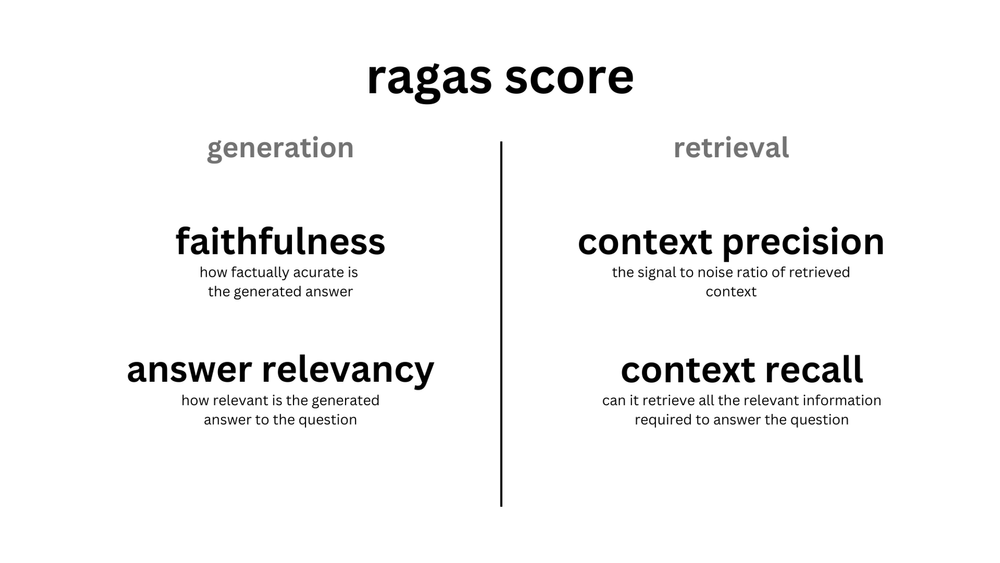

In [22]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness
)

In [24]:
from ragas import evaluate
sample_from_ragas = pd.read_csv('rag_token_512.csv')
sample_from_ragas.head(10)

,question,answer,contexts,ground_truths
0,What is the purpose of oversampling in Qdrant ...,Oversampling in Qdrant is a special technique...,"['document:Here, we show how the accuracy of b...",['Oversampling in Qdrant search process define...
1,How does Qdrant address the search accuracy pr...,Qdrant uses a different approach that does no...,"['document:Here, we show how the accuracy of b...",['Qdrant uses a different approach that does n...
2,What is the difference between regular and neu...,Regular search uses traditional algorithms an...,"['document:Here, we show how the accuracy of b...",['Regular full-text search involves searching ...
3,How can I use Qdrant as a vector store in Lang...,To use Qdrant as a vector store in Langchain ...,"['document:Here, we show how the accuracy of b...",['You can use Qdrant as a vector store in Lang...
4,How did Dust leverage compression features in ...,Dust leveraged the control of the MMAP payloa...,"['document:Here, we show how the accuracy of b...",['Dust leveraged the control of the MMAP paylo...
5,Why do we still need keyword search?,Keyword search is still necessary because it ...,"['document:Here, we show how the accuracy of b...",['Keyword search is still useful in cases of o...
6,What principles did Qdrant follow while design...,Qdrant followed the principle of using refere...,"['document:Here, we show how the accuracy of b...",['Qdrant followed the principles of doing comp...
7,What models does Qdrant support for embedding ...,Qdrant supports models from OpenAI for embedd...,"['document:Here, we show how the accuracy of b...",['Qdrant supports a reasonable range of models...
8,How can you parallelize the upload of a large ...,"In Qdrant, each collection is split into shar...","['document:Here, we show how the accuracy of b...","['By creating multiple shards in Qdrant, you c..."
9,What is the significance of maximizing the dis...,The significance of maximizing the distance b...,"['document:Here, we show how the accuracy of b...",['Maximizing the distance between all points i...


In [25]:
result = evaluate(
    rag_response_dataset,
    metrics=[
        answer_correctness,
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ],
)


Evaluating:   0%|          | 0/405 [00:00<?, ?it/s]

In [26]:
evaluation_result_df_512 = result.to_pandas()
evaluation_result_df_512.head(20)

,question,answer,contexts,ground_truths,ground_truth,answer_correctness,answer_relevancy,faithfulness,context_recall,context_precision
0,What is the purpose of oversampling in Qdrant ...,Oversampling in Qdrant is a special technique...,"[document:Here, we show how the accuracy of bi...",[Oversampling in Qdrant search process defines...,Oversampling in Qdrant search process defines ...,0.879722,0.935885,0.00,1.0,0.5
1,How does Qdrant address the search accuracy pr...,Qdrant uses a different approach that does no...,"[document:Here, we show how the accuracy of bi...",[Qdrant uses a different approach that does no...,Qdrant uses a different approach that does not...,0.535845,0.881327,NaN,1.0,0.0
2,What is the difference between regular and neu...,Regular search uses traditional algorithms an...,"[document:Here, we show how the accuracy of bi...",[Regular full-text search involves searching f...,Regular full-text search involves searching fo...,0.792955,0.989907,0.00,1.0,0.0
3,How can I use Qdrant as a vector store in Lang...,To use Qdrant as a vector store in Langchain ...,"[document:Here, we show how the accuracy of bi...",[You can use Qdrant as a vector store in Langc...,You can use Qdrant as a vector store in Langch...,0.781019,0.973575,0.00,1.0,1.0
4,How did Dust leverage compression features in ...,Dust leveraged the control of the MMAP payloa...,"[document:Here, we show how the accuracy of bi...",[Dust leveraged the control of the MMAP payloa...,Dust leveraged the control of the MMAP payload...,0.614064,0.966258,1.00,1.0,1.0
5,Why do we still need keyword search?,Keyword search is still necessary because it ...,"[document:Here, we show how the accuracy of bi...",[Keyword search is still useful in cases of ou...,Keyword search is still useful in cases of out...,0.467114,0.978159,0.00,1.0,0.0
6,What principles did Qdrant follow while design...,Qdrant followed the principle of using refere...,"[document:Here, we show how the accuracy of bi...",[Qdrant followed the principles of doing compa...,Qdrant followed the principles of doing compar...,0.516561,0.993356,0.75,1.0,0.0
7,What models does Qdrant support for embedding ...,Qdrant supports models from OpenAI for embedd...,"[document:Here, we show how the accuracy of bi...","[Qdrant supports a reasonable range of models,...","Qdrant supports a reasonable range of models, ...",0.587494,1.000000,0.00,1.0,0.0
8,How can you parallelize the upload of a large ...,"In Qdrant, each collection is split into shar...","[document:Here, we show how the accuracy of bi...","[By creating multiple shards in Qdrant, you ca...","By creating multiple shards in Qdrant, you can...",0.669637,0.857855,0.00,1.0,1.0
9,What is the significance of maximizing the dis...,The significance of maximizing the distance b...,"[document:Here, we show how the accuracy of bi...",[Maximizing the distance between all points in...,Maximizing the distance between all points in ...,0.743553,1.000000,0.00,1.0,1.0


### **16. How to evaluate using the baseline evaluation dataset**

In [40]:

# loading the eval dataset from HF
qdrant_qa = load_dataset("atitaarora/qdrant_docs_qna_ragas")

#Converting contexts string to list of contexts for running further evals
qdrant_qa_eval = load_dataset("atitaarora/qdrant_docs_qna_ragas", split="train")
column_to_filter = "contexts"
# Filter rows with null values in the specified column
filtered_dataset = qdrant_qa_eval.filter(lambda example, column_name=column_to_filter: example[column_name] is not None)
#len(filtered_dataset)

filtered_dataset = filtered_dataset.map(lambda x: {"contexts":[x["contexts"]]})


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [41]:
from ragas import evaluate

result = evaluate(
    filtered_dataset,
    metrics=[
        answer_correctness,
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ],
)


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

In [43]:
evaluation_result_df = result.to_pandas()
evaluation_result_df.head(20)

,question,ground_truth,answer,source,contexts,answer_correctness,answer_relevancy,faithfulness,context_recall,context_precision
0,What is the purpose of the locking feature in ...,The locking feature in Qdrant administration t...,The locking feature in Qdrant administration t...,documentation/guides/administration.md,[title: Administration\n\nweight: 10\n\naliase...,1.0,1.000000,1.000000,0.500000,1.0
1,What is the significance of the `on_disk_paylo...,The `on_disk_payload` setting in the storage c...,The `on_disk_payload` setting in the storage c...,documentation/guides/configuration.md,[storage:\n\n # Where to store all the data\n...,1.0,0.953128,1.000000,1.000000,1.0
2,What is the significance of the parameter `max...,The `max_segment_size_kb` parameter in the con...,The `max_segment_size_kb` parameter in the con...,documentation/guides/configuration.md,[default_segment_number: 0\n\n\n\n # Do not...,1.0,0.979010,1.000000,1.000000,1.0
3,What is the significance of the `indexing_thre...,The `indexing_threshold_kb` parameter specifie...,The `indexing_threshold_kb` parameter specifie...,documentation/guides/configuration.md,[memmap_threshold_kb: null\n\n\n\n # Maximu...,1.0,0.969266,1.000000,1.000000,1.0
4,How can you optimize Qdrant for minimizing lat...,To optimize Qdrant for minimizing latency in s...,To optimize Qdrant for minimizing latency in s...,documentation/guides/optimize.md,"[- `exact` - if set to `true`, will perform ex...",1.0,1.000000,1.000000,1.000000,1.0
5,How can Qdrant be configured to optimize throu...,To optimize throughput in Qdrant and utilize m...,To optimize throughput in Qdrant and utilize m...,documentation/guides/optimize.md,[.get();\n\n```\n\n\n\n```csharp\n\nusing Qdra...,1.0,0.924237,1.000000,1.000000,1.0
6,How can one enable distributed deployment mode...,To enable distributed deployment mode in Qdran...,To enable distributed deployment mode in Qdran...,documentation/guides/distributed_deployment.md,[---\n\ntitle: Distributed Deployment\n\nweigh...,1.0,1.000000,1.000000,1.000000,1.0
7,What is the recommended approach for determini...,"When creating a collection using Qdrant, it is...","When creating a collection using Qdrant, it is...",documentation/guides/distributed_deployment.md,[using Qdrant.Client.Grpc;\n\n\n\nvar client =...,1.0,0.967004,1.000000,1.000000,1.0
8,How is the discovery score computed in the con...,"In the context provided, the discovery score i...","In the context provided, the discovery score i...",documentation/concepts/explore.md,"[-1, &\quad s(v^+) < s(v^-)\n\n\end{cases}\n\n...",1.0,0.968043,1.000000,1.000000,1.0
9,How does Qdrant optimize storage at the segmen...,Qdrant optimizes storage at the segment level ...,Qdrant optimizes storage at the segment level ...,documentation/concepts/optimizer.md,[---\n\ntitle: Optimizer\n\nweight: 70\n\nalia...,1.0,1.000000,1.000000,1.000000,1.0
